In [105]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [106]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
c = Matrix(DataFrame(CSV.File("../origin_destination_times.csv")))
c = c[:, 2:size(c)[2]];

t = c  #let's consider in this initial model that the travel cost and the time and equivalent. 

20×45 Matrix{Any}:
 7.6167  7.7833  8.5167  8.35    6.8     …  6.7833  8.35    6.1833  7.1833
 8.0167  8.1833  8.9167  8.7667  7.2        7.2     8.7667  6.5833  7.5833
 1.85    1.85    0.6     0.7667  2.9833     4.4833  0.7667  7.25    5.0167
 7.9667  8.1333  8.8667  8.7     7.15       7.15    8.7     6.5333  7.5333
 3.9333  3.2333  3.9667  4.2     0.2667     2.3     4.2     5.5167  3.2833
 4.5333  3.8333  4.5667  4.8     0.4167  …  2.9     4.8     6.1167  3.8833
 5.3667  6.4333  6.05    6.1167  4.55       7.15    6.1167  6.5333  4.95
 4.8833  5.95    5.5667  5.6333  4.0667     5.2167  5.6333  5.8     4.4667
 4.8667  5.9167  5.5167  5.5833  4.2833     5.7667  5.5833  2.7667  1.8667
 3.8833  4.9333  4.5333  4.6     3.0333     4.5167  4.6     3.0167  1.7667
 3.4833  4.5333  4.15    4.2167  2.6667  …  4.15    4.2167  5.3     3.05
 1.3167  1.2333  0.2667  0.9833  3.2        4.7     0.9833  6.9333  4.5833
 4.0     5.0667  4.6667  4.7333  3.4333     4.9     4.7333  2.1667  1.0
 3.2     4.25

In [107]:
# Constants
N = 9 ; # number of passengers
K = 3 ;  # number of shuttles

In [108]:
# Data
data = Matrix(DataFrame(CSV.File("../demand.csv")));

q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

In [109]:
data

20×8 Matrix{Float64}:
 0.0  42.3638  -71.0886   0.0  0.0    0.0       0.0     1000.0
 1.0  42.3588  -71.0999   1.0  0.5  178.115   173.115    183.115
 2.0  42.3603  -71.0858   1.0  0.5  113.882   108.882    118.882
 3.0  42.3568  -71.0957   1.0  0.5  144.166   139.166    149.166
 4.0  42.3603  -71.0858   1.0  0.5  114.8     109.8      119.8
 5.0  42.3588  -71.0999   1.0  0.5  124.311   119.311    129.311
 6.0  42.3561  -71.0979   1.0  0.5  171.253   166.253    176.253
 7.0  42.355   -71.1019   1.0  0.5  109.443   104.443    114.443
 8.0  42.3599  -71.102    1.0  0.5  120.032   115.032    125.032
 9.0  42.362   -71.0983   1.0  0.5   90.1133   85.1133    95.1133
 1.0  42.3592  -71.0976  -1.0  0.5  179.865   178.115    353.115
 2.0  42.3601  -71.087   -1.0  0.5  115.699   113.882    295.552
 3.0  42.3556  -71.0996  -1.0  0.5  147.449   144.166    472.496
 4.0  42.3589  -71.0973  -1.0  0.5  121.183   114.8      753.13
 5.0  42.3592  -71.0976  -1.0  0.5  126.061   124.311    299.311
 6.0  4

### The model

In [110]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)

T = fill(1000, K)                # maximum duration of route k
L = 1000                         # maximum time of a drive
Q = fill(1, K)                # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1

@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# updating the load of the vehicle
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [111]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 387 rows, 1329 columns and 4143 nonzeros
Model fingerprint: 0xb1dac240
Model has 2400 quadratic constraints
Variable types: 69 continuous, 1260 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [5e-01, 1e+01]
  Objective range  [1e-01, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve added 366 rows and 0 columns
Presolve removed 0 rows and 528 columns
Presolve time: 0.02s
Presolved: 783 rows, 816 columns, 6723 nonzeros
Variable types: 78 continuous, 738 integer (738 binary)

Root relaxation: objective 4.550000e+01, 314 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [112]:
u_values = value.(u)

20×3 Matrix{Float64}:
   0.0      40.3051     0.0
 173.115   173.115    173.115
 118.882   114.96     109.599
 139.166   149.166    139.166
 109.8     119.8      109.8
 119.311   119.311    119.311
 166.253   166.253    166.253
 114.443   104.443    104.443
 118.716   115.449    115.449
  85.1133   95.1133    85.1133
 178.598   178.598    178.598
 123.165   119.243    113.882
 150.97    160.97     150.97
 114.8     124.8      114.8
 171.332   171.332    171.332
 173.12    173.12     173.12
 119.443   109.443    109.443
 123.3     120.032    120.032
  90.1133  100.113     90.1133
 928.978   179.603   1000.0

In [113]:
r_values = value.(r)

9-element Vector{Float64}:
  4.9833
  3.7833
 11.303494772439706
  4.5
 51.520756077973815
  6.3667
  4.5
  4.0833
  4.5

In [114]:
w_values = round.(Int, value.(w))

20×3 Matrix{Int64}:
 0  0  0
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 1  1  1

In [115]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    print(cars_used)
    
    println("Number of cars used: $(sum(cars_used))")
    println("The car(s) used are(is): ", cars_used)


    # plot the depot
    Plots.scatter([df[1, 2]], [df[2*N+2, 3]], 
        size = (plot_size[1], plot_size[2]),
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        title="Result for different cars",  
        legend = :outertopleft,
        format=:png)

    # plot all pick-up points
    for i=2:N+1
        pass_ID = round(Integer, df[i,1])

        Plots.scatter!([df[i, 2]], [df[i, 3]],
            color="lightgreen", 
            xlabel="x", ylabel="y",
            labels="PickUp ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)

        Plots.scatter!([df[i+N, 2]], [df[i+N, 3]],
            color="red", 
            xlabel="x", ylabel="y",
            labels="DropOff ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i+N, 2], df[i+N, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)
    end

    colors = ["black", "red", "green", "blue", "pink"]
    for car in cars_used
        vals = findall(x_val[:, :, car] .== 1)
        print(vals)
        for elem in vals
            i,j = elem[1], elem[2]
            print(i, " ", j, " --> ")
            Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end
        
        # for i in 1:2*N+2
        #     for j in 1:2*N+2
        #         if x_val[i, j, car] == 1
        #             print(i, " ", j, " --> ")
        #             Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        #         end
        #     end
        # end
    end

    # plot the depot
    Plots.scatter!([df[1, 2]], [df[2*N+2, 3]], 
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        format=:png)

end


plot_route (generic function with 1 method)

[1, 2, 3]Number of cars used: 6
The car(s) used are(is): [1, 2, 3]
CartesianIndex{2}[CartesianIndex(19, 5), CartesianIndex(14, 9), CartesianIndex(1, 10), CartesianIndex(5, 14), CartesianIndex(9, 18), CartesianIndex(10, 19), CartesianIndex(18, 20)]19 5 --> 14 9 --> 1 10 --> 5 14 --> 9 18 --> 10 19 --> 18 20 --> CartesianIndex{2}[CartesianIndex(17, 3), CartesianIndex(12, 4), CartesianIndex(13, 7), CartesianIndex(1, 8), CartesianIndex(3, 12), CartesianIndex(4, 13), CartesianIndex(7, 16), CartesianIndex(8, 17), CartesianIndex(16, 20)]17 3 --> 12 4 --> 13 7 --> 1 8 --> 3 12 --> 4 13 --> 7 16 --> 8 17 --> 16 20 --> CartesianIndex{2}[CartesianIndex(15, 2), CartesianIndex(1, 6), CartesianIndex(2, 11), CartesianIndex(6, 15), CartesianIndex(11, 20)]15 2 --> 1 6 --> 2 11 --> 6 15 --> 11 20 --> 

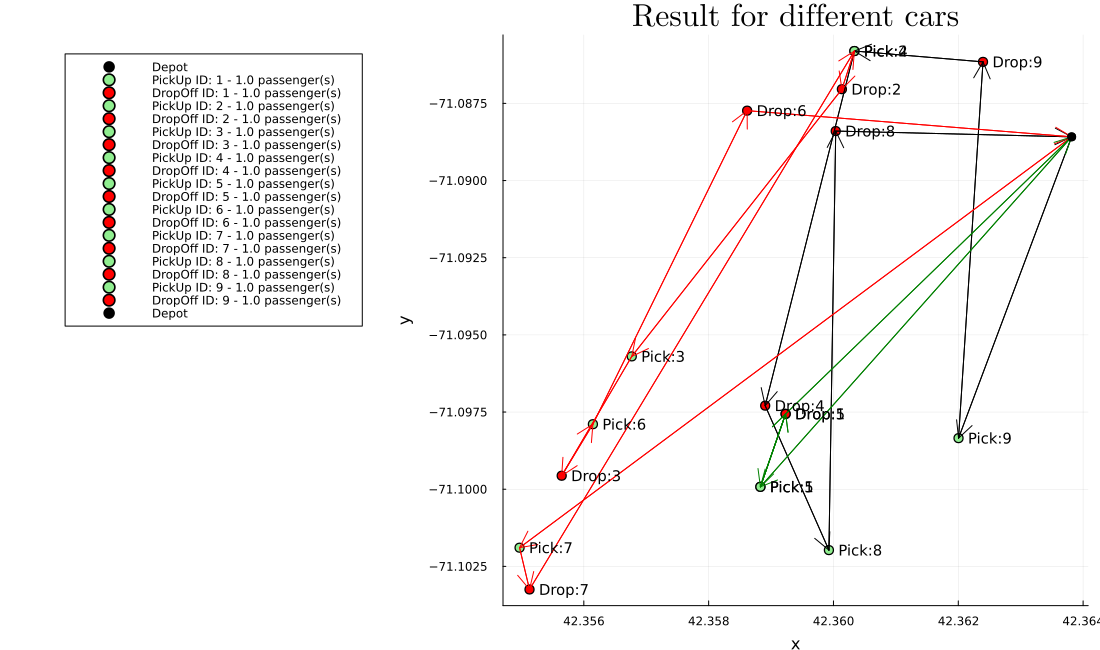

In [116]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))

plot_route(data, x_values, w_values, [1100, 650])